The dataset is the repackaged data put together by the Berkeley Earth which is affiliated with Lawrence Berkeley National Laboratory. The dataset has multiple features as below:

1) Date: starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures.

2) LandAverageTemperature: global average land temperature in celsius

3) LandAverageTemperatureUncertainty: the 95% confidence interval around the average

4) LandMaxTemperature: global average maximum land temperature in celsius

5) LandMaxTemperatureUncertainty: the 95% confidence interval around the maximum land temperature

6) LandMinTemperature: global average minimum land temperature in celsius

7) LandMinTemperatureUncertainty: the 95% confidence interval around the minimum land temperature

8) LandAndOceanAverageTemperature: global average land and ocean temperature in celsius

9) LandAndOceanAverageTemperatureUncertainty: the 95% confidence interval around the global average land and ocean temperature

For this analysis, we will be only looking at date and Land Average Temperature. In other words, univariate time series.

The objective of this study is to forecast the future average land temperature using traditional statistical models and deep learning models and compare the predictive performance and determine which approach yields the most accurate long term temperature forecasts.

## Data Loading and Cleaning

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.3 MB/s eta 0:00:00


In [2]:
# importing libraries
import sys
import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import numpy as np
import tensorflow as tf

from pprint import pprint

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
# check if GPU is available

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [4]:
# Set the path to the file you'd like to load
file_path = "GlobalTemperatures.csv"

# Load the latest version
df = kagglehub. dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "berkeleyearth/climate-change-earth-surface-temperature-data",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
  # Dataset Link: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
)

Using Colab cache for faster access to the 'climate-change-earth-surface-temperature-data' dataset.


In [5]:
# first few records of dataset

pprint(df.head(n=4).to_dict())

{'LandAndOceanAverageTemperature': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandAndOceanAverageTemperatureUncertainty': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandAverageTemperature': {0: 3.0340000000000003, 1: 3.083, 2: 5.626, 3: 8.49},
 'LandAverageTemperatureUncertainty': {0: 3.574, 1: 3.702, 2: 3.076, 3: 2.451},
 'LandMaxTemperature': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandMaxTemperatureUncertainty': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandMinTemperature': {0: nan, 1: nan, 2: nan, 3: nan},
 'LandMinTemperatureUncertainty': {0: nan, 1: nan, 2: nan, 3: nan},
 'dt': {0: '1750-01-01', 1: '1750-02-01', 2: '1750-03-01', 3: '1750-04-01'}}


In [6]:
# subsetting only dt and LandAverageTemperature columns from the dataset

temp_df = df[['dt', 'LandAverageTemperature']]

In [7]:
# few data of subsetted dataset

pprint(temp_df.head(n=4).to_dict())

{'LandAverageTemperature': {0: 3.0340000000000003, 1: 3.083, 2: 5.626, 3: 8.49},
 'dt': {0: '1750-01-01', 1: '1750-02-01', 2: '1750-03-01', 3: '1750-04-01'}}


In [8]:
# renaming column names

temp_df = temp_df.rename(columns = {'dt': 'Date', 'LandAverageTemperature': 'avg_temp'})

In [9]:
# checking duplicate values

pprint(temp_df[temp_df.duplicated()].to_dict())

{'Date': {}, 'avg_temp': {}}


In [10]:
# checking null values

pprint(temp_df[temp_df.isnull().any(axis=1)].to_dict())

{'Date': {10: '1750-11-01',
          16: '1751-05-01',
          18: '1751-07-01',
          21: '1751-10-01',
          22: '1751-11-01',
          23: '1751-12-01',
          25: '1752-02-01',
          28: '1752-05-01',
          29: '1752-06-01',
          30: '1752-07-01',
          31: '1752-08-01',
          32: '1752-09-01'},
 'avg_temp': {10: nan,
              16: nan,
              18: nan,
              21: nan,
              22: nan,
              23: nan,
              25: nan,
              28: nan,
              29: nan,
              30: nan,
              31: nan,
              32: nan}}


In [11]:
# Dropping Null Values

temp_df = temp_df.dropna()

In [12]:
# setting index for time series

temp_df['Date'] = pd.to_datetime(temp_df['Date'])

temp_df = temp_df.set_index('Date').sort_index()


In [13]:
# only getting data from 1753

temp_df = temp_df['avg_temp']['1753-01-01':]

In [14]:
# information about the data

temp_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3156 entries, 1753-01-01 to 2015-12-01
Series name: avg_temp
Non-Null Count  Dtype  
--------------  -----  
3156 non-null   float64
dtypes: float64(1)
memory usage: 49.3 KB


In [15]:
# describe the data

pprint(temp_df.describe().to_dict())

{'25%': 4.312,
 '50%': 8.628499999999999,
 '75%': 12.549,
 'count': 3156.0,
 'max': 19.021,
 'mean': 8.379347275031686,
 'min': -2.08,
 'std': 4.3803266334795605}


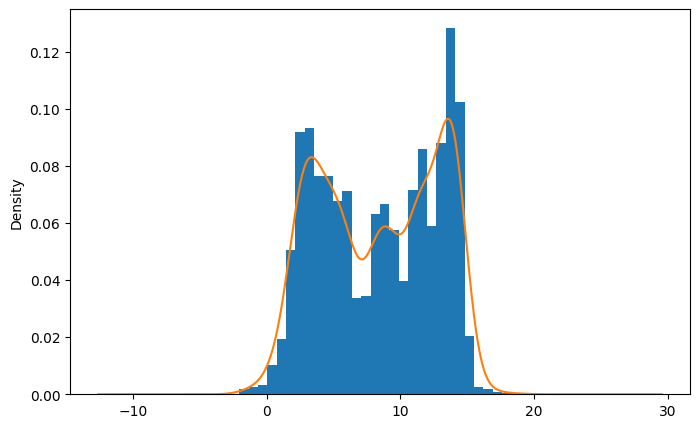

In [16]:
# look at the distribution of temperature

fig, ax = plt.subplots(figsize=(8,5))
temp_df.plot(kind='hist', ax=ax, density=True, bins=30)
temp_df.plot(kind='kde', ax=ax, label='Density')
plt.show()

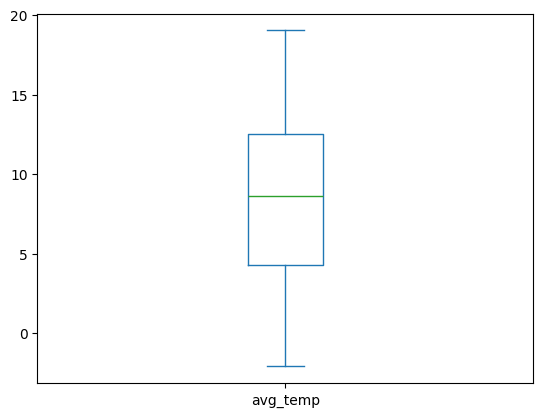

In [17]:
# box plot for temperature

temp_df.plot(kind='box')
plt.show()

In [18]:
pprint(temp_df.head().to_dict())

{Timestamp('1753-01-01 00:00:00'): 2.039,
 Timestamp('1753-02-01 00:00:00'): 0.7149999999999999,
 Timestamp('1753-03-01 00:00:00'): 5.424,
 Timestamp('1753-04-01 00:00:00'): 8.272,
 Timestamp('1753-05-01 00:00:00'): 12.186}


In [ ]:
# temp_df = temp_df.asfreq("MS")   # Monthly Start frequency

In [19]:
# sort the series

temp_df = temp_df.sort_index()

In [20]:
# final values of series

pprint(temp_df.tail(n=4).to_dict())

{Timestamp('2015-09-01 00:00:00'): 12.999,
 Timestamp('2015-10-01 00:00:00'): 10.800999999999998,
 Timestamp('2015-11-01 00:00:00'): 7.433,
 Timestamp('2015-12-01 00:00:00'): 5.518}


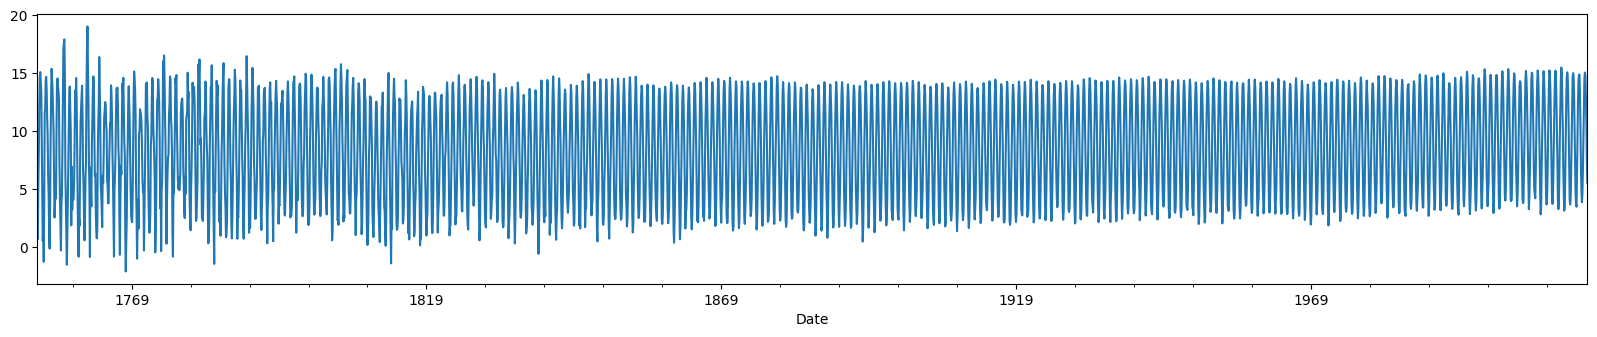

In [21]:
# average temperature plot


temp_df.plot(y='avg_temp', figsize=(20, 3.5))
plt.show()

<Axes: xlabel='Date'>

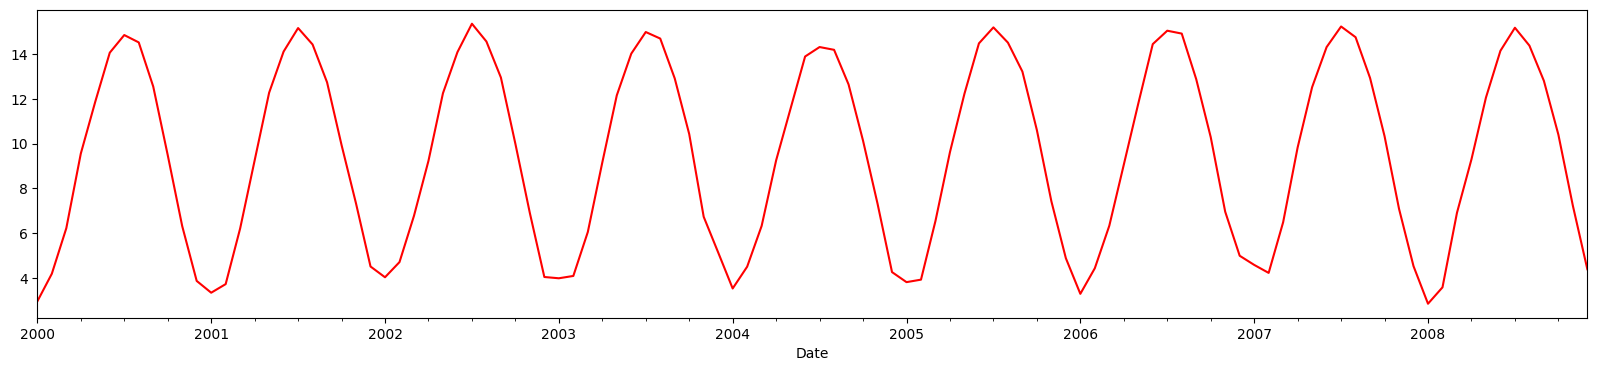

In [22]:
# average temperature subset plot

temp_df['2000-01-01':'2008-12-31'].plot(y = 'avg_temp', color='red', figsize=(20,4))

We can see from the plot above that there is a strong yearly seasonality. It is so strong that copying last year's value for this year will give us reasonable good solution. This **naive forecasting** will be one of our baseline.

We are shifting the data by 12 months.

In [23]:
diff_year = temp_df.diff(12) # 12 month differenced series

diff_year.abs().mean()

print('Average 12 Month change (MAE):')
(diff_year).abs().dropna().mean()

Average 12 Month change (MAE):


np.float64(0.6570613867684478)

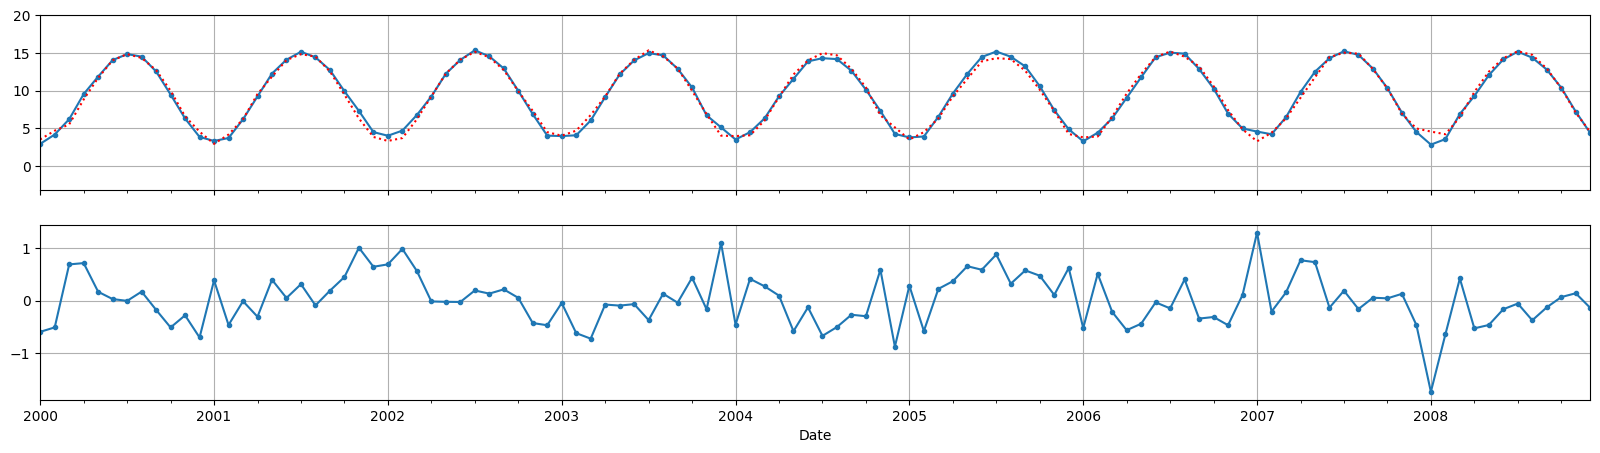

In [24]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 5))

temp_df['2000-01-01':'2008-12-31'].plot(ax=axs[0], legend=False, marker='.') # original time series
temp_df.shift(12).plot(ax=axs[0], grid=True, legend=False, linestyle=':', color = 'red') # lagged series

diff_year['2000-01-01':'2008-12-31'].plot(ax=axs[1], grid=True, marker='.')
plt.show()

We can see from the plot above that lagged version of time series closely follows the original time series. We have autocorrelation here.

From the differenced series, we can see that we have removed seasonality from the dataset. Except for few like in 2008 there is a strong dip. Maybe something caused this.

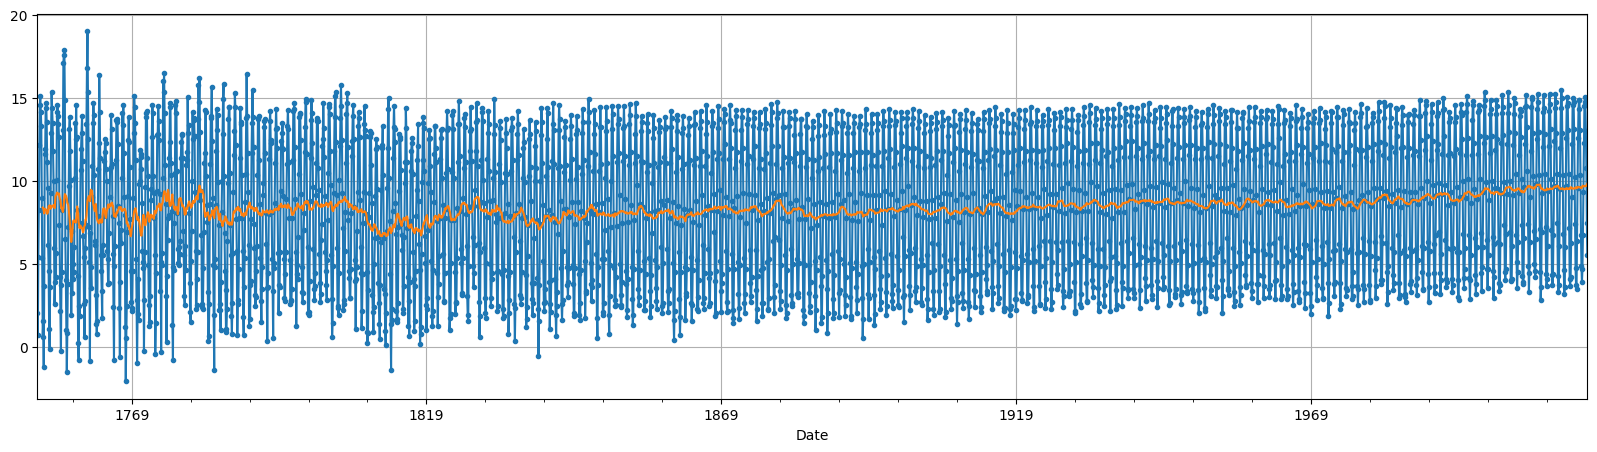

In [25]:
# rolling 12 month average to see the trend of Series

period = slice('1753', '2015')
rolling_average_12_months = temp_df[period].rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(20,5))
temp_df[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

## Classical Statistical Model

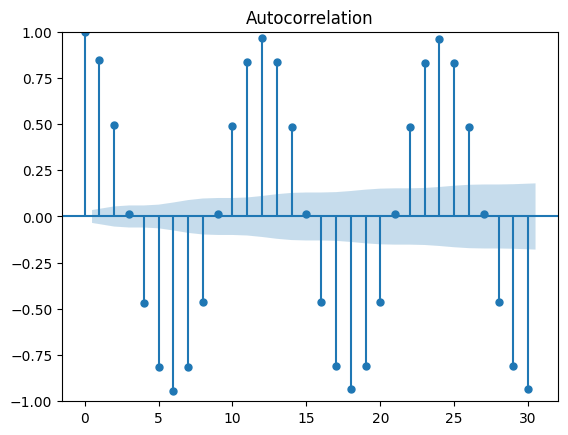

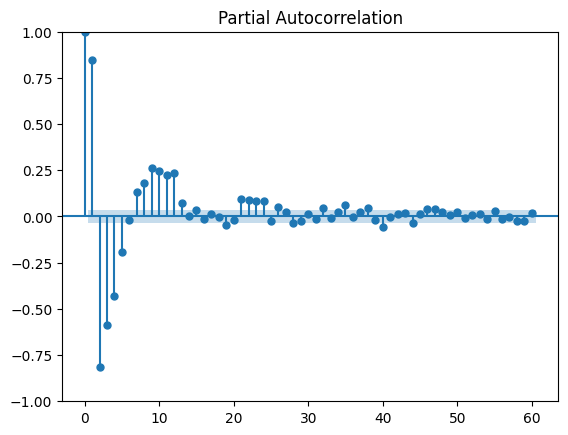

In [26]:
plot_acf(temp_df, lags=30)
plot_pacf(temp_df, lags=60)
plt.show()
# plt.savefig('auto_acf.jpeg')

Determining Differencing (d, D) from the Original Series

| **Plot Feature**                     | **Observation / Interpretation**                                                                                                      | **Conclusion (Model Requirement)**                                            |
|-------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| **ACF Slow Decay at Lags 1–11**     | The correlation between \(Y_t\) and \(Y_{t-k}\) is persistent and does not drop quickly → indicates a linear trend (non-stationarity). | Apply **Non-Seasonal Differencing** (\(d = 1\)) to stabilize the mean.        |
| **ACF Large Spikes at Lags 12, 24** | Large repeated spikes every 12 months confirm a strong annual seasonal cycle.                                                          | Apply **Seasonal Differencing** (\(D = 1\), Period \(S = 12\)).               |
| **PACF Spikes at Lags 1 and 2**     | Strong spikes at lags 1 and 2 indicate direct dependence on the previous two months.                                                   | Include **Non-Seasonal AR terms** (\(p \approx 1\)).                           |
| **PACF Spikes at Lags 12 and 24**   | Significant spikes at lags 12 and 24 indicate direct yearly influence even after differencing.                                         | Include **Seasonal AR terms** (\(P \approx 1\)).                               |


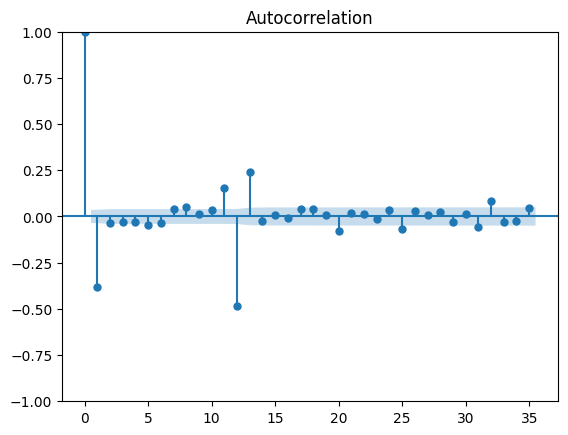

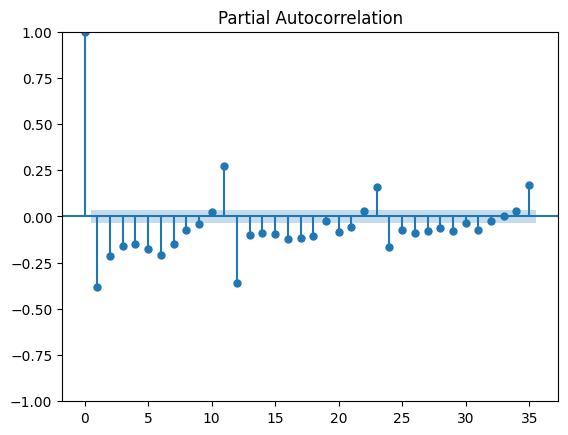

In [113]:
# differenced series pacf and acf

plot_acf(temp_df.diff(1).dropna().diff(12).dropna())
plt.savefig('auto_acf_diff.jpeg')
plot_pacf(temp_df.diff(1).dropna().diff(12).dropna())
plt.savefig('auto_pacf_diff.jpeg')
# plt.show()


Determining Lag Orders (p, q, P, Q) from the Differenced Series

After applying the required $d=1$ and $D=1$ or $(s=12)$ differencing, the following analysis of the resulting stationary series' plots determines the remaining AR and MA terms:

| **Plot Feature (Differenced Series)** | **Observation / Interpretation**                                                                 | **Conclusion (Model Requirement)**                     |
|--------------------------------------|---------------------------------------------------------------------------------------------------|--------------------------------------------------------|
| **ACF Sharp Cutoff at Lag 1**        | A single significant spike at Lag 1 followed by an immediate drop to zero.                       | Include **Non-Seasonal MA term** (\(q = 1\)).          |
| **PACF Sharp Cutoff at Lag 1**       | A single significant spike at Lag 1 followed by an immediate drop to zero.                       | Include **Non-Seasonal AR term** (\(p = 1\)).          |
| **ACF Significant Spike at Lag 12**  | One major spike at seasonal lag 12, then rapid decay.                                            | Include **Seasonal MA term** (\(Q = 1\)).              |
| **PACF Significant Spike at Lag 12** | One major spike at seasonal lag 12, then rapid decay.                                            | Include **Seasonal AR term** (\(P = 1\)).              |


The final, fully diagnosed SARIMA model order is:$$\text{SARIMA}(1, 1, 1) \times (1, 1, 1)_{12}$$

In [28]:
# Lets remove trend and seasonality, to make our dataset stationary

# remove trend
temp_df_diff_1 = temp_df.diff(1).dropna()
# remove seasonality
temp_df_diff_2 = temp_df_diff_1.diff(12).dropna()

<Axes: xlabel='Date'>

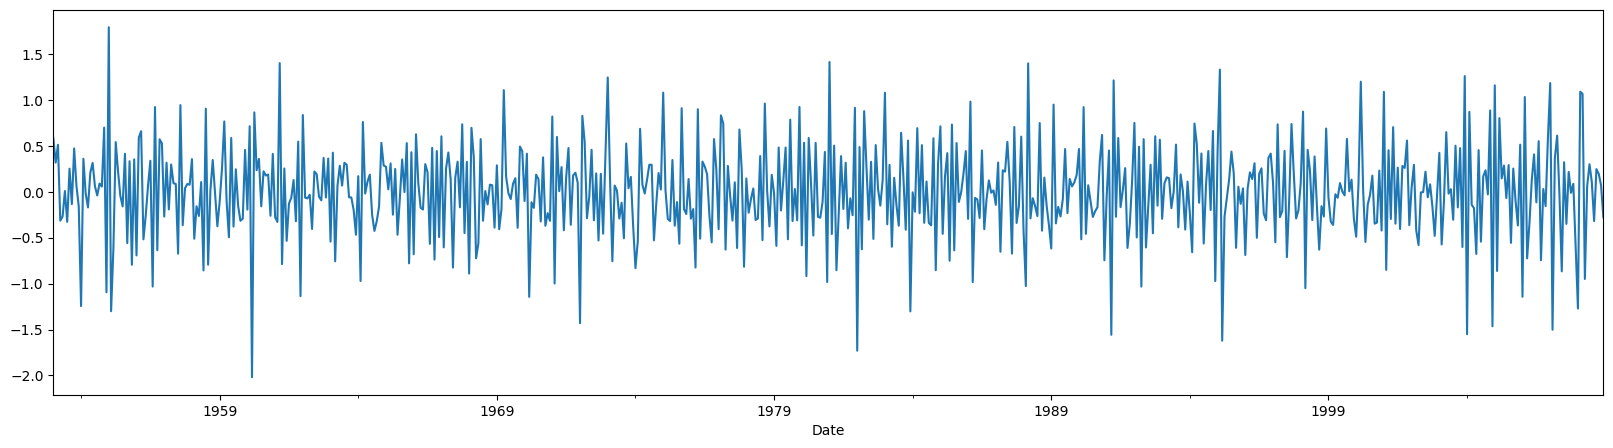

In [29]:
# verify time series is stationary

temp_df_diff_2['1953-01-01':'2008-12-31'].plot(figsize=(20,5))

### ARIMA and Auto ARIMA Model

Fitting ARIMA model

ARIMA has (p, d, q):

p → AR (autoregressive) order (how many past months to use)

d → differencing order (to remove trend)

q → MA (moving average) order (how many past errors to use)

Seasonal part (P, D, Q, s):

P → seasonal AR (how many past years to use)

D → seasonal differencing → we differenced 12 → D=1

Q → seasonal MA

s → seasonal period → 12 months

In [30]:
# model training

model = ARIMA(temp_df.asfreq('MS')[:-12], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

In [31]:
# 12 step ahead forecast

n_periods = 12
y_pred = results.get_forecast(steps=n_periods).predicted_mean
print(y_pred)

2015-01-01     3.754539
2015-02-01     4.196656
2015-03-01     6.349470
2015-04-01     9.455053
2015-05-01    12.283310
2015-06-01    14.396943
2015-07-01    15.237030
2015-08-01    14.798393
2015-09-01    13.006049
2015-10-01    10.337816
2015-11-01     7.046513
2015-12-01     4.690901
Freq: MS, Name: predicted_mean, dtype: float64


In [32]:
# trying auto arima and see what stepwise search finds us in the search space

auto_model = auto_arima(temp_df.asfreq('MS')[:-12],
                        seasonal=True,
                        m=12,
                        start_p=0,
                        start_q=0,
                        max_p=2,
                        max_q=3,
                        start_P=0,
                        start_Q=0,
                        max_P=2,
                        max_Q=2,
                        d=1,
                        D=1,
                        trace=True,
                        stepwise=True
                        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=10267.626, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8963.960, Time=0.94 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.77 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=9774.722, Time=0.17 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8712.603, Time=1.58 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.61 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.43 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=9181.058, Time=1.10 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8557.208, Time=2.18 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=8814.400, Time=1.04 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.67 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=17.73 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=13.49 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=8559.20

In [33]:
print(auto_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 3144
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -4273.604
Date:                            Tue, 25 Nov 2025   AIC                           8557.208
Time:                                    06:37:40   BIC                           8587.453
Sample:                                01-01-1753   HQIC                          8568.063
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4568      0.010    -46.906      0.000      -0.476      -0.438
ar.L2         -0.2215      0.009   

In [34]:
# 12 step ahead forecast with auto arima

n_periods = 12
y_pred_auto, conf_interval = auto_model.predict(n_periods=n_periods, return_conf_int=True)
print(y_pred_auto)


2015-01-01     3.636860
2015-02-01     3.806583
2015-03-01     6.352016
2015-04-01     9.519322
2015-05-01    12.535965
2015-06-01    14.547019
2015-07-01    15.061134
2015-08-01    14.872883
2015-09-01    13.184751
2015-10-01    10.420144
2015-11-01     7.162947
2015-12-01     4.682380
Freq: MS, dtype: float64


In [35]:
y_true = temp_df[-n_periods:]
pprint(y_true.to_dict())

{Timestamp('2015-01-01 00:00:00'): 3.881,
 Timestamp('2015-02-01 00:00:00'): 4.664,
 Timestamp('2015-03-01 00:00:00'): 6.74,
 Timestamp('2015-04-01 00:00:00'): 9.313,
 Timestamp('2015-05-01 00:00:00'): 12.312,
 Timestamp('2015-06-01 00:00:00'): 14.505,
 Timestamp('2015-07-01 00:00:00'): 15.050999999999998,
 Timestamp('2015-08-01 00:00:00'): 14.755,
 Timestamp('2015-09-01 00:00:00'): 12.999,
 Timestamp('2015-10-01 00:00:00'): 10.800999999999998,
 Timestamp('2015-11-01 00:00:00'): 7.433,
 Timestamp('2015-12-01 00:00:00'): 5.518}


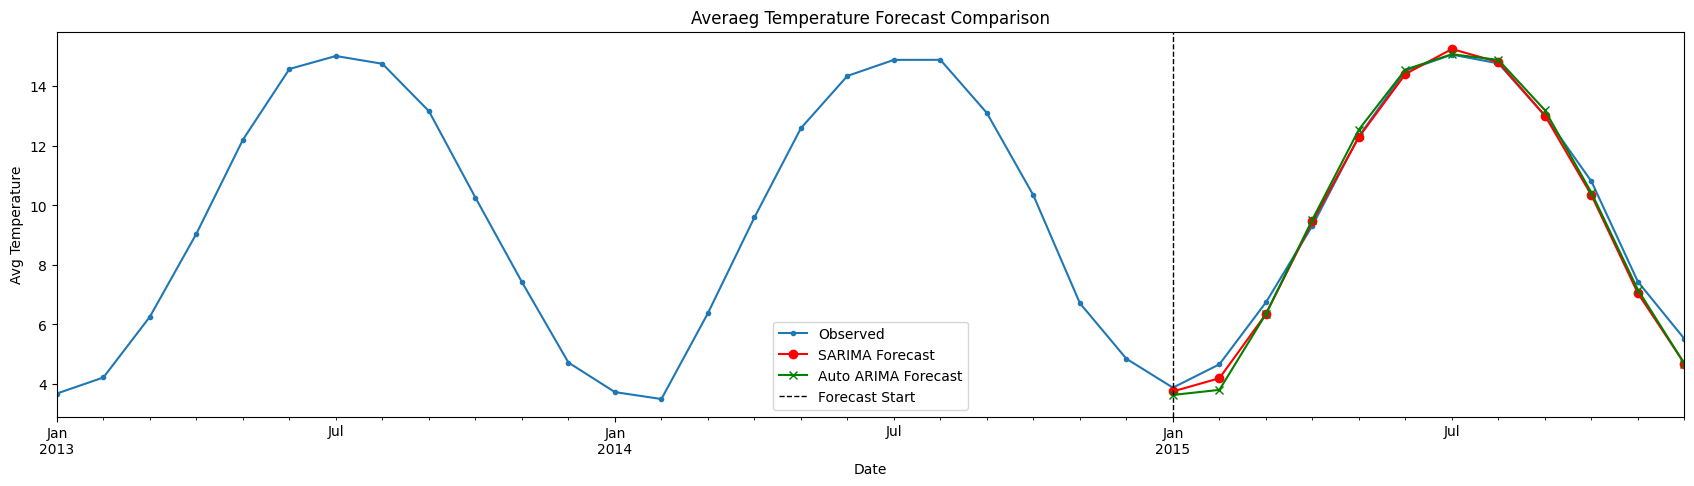

In [36]:
start_date, end_date = '2013-01-01', '2015-12-31'
time_period = pd.date_range(start_date, end_date, freq='MS')

fig, ax = plt.subplots(figsize=(21, 5))
temp_df.loc[time_period].plot(ax=ax, marker='.', label='Observed', grid=True)
y_pred.plot(ax=ax, marker='o', color='r', label='SARIMA Forecast')
y_pred_auto.plot(ax=ax, marker='x', color='g', label='Auto ARIMA Forecast')
ax.axvline(pd.Timestamp('2015-01-01'), linestyle='--', color='k', linewidth=1, label='Forecast Start')
plt.title("Averaeg Temperature Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Avg Temperature")
plt.legend()
plt.show()


In [37]:
mae_manual = mean_absolute_error(y_true, y_pred)
mae_auto = mean_absolute_error(y_true, y_pred_auto)

print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("MAE Naive Forecast:", (diff_year).abs().dropna().mean())

MAE Manual ARIMA: 0.26469807440120835
MAE Auto ARIMA: 0.3135120769256071
MAE Naive Forecast: 0.6570613867684478


## Neural Network Models

In [46]:
# train, test and valid split

In [47]:
temp_df.head()

,avg_temp
Date,
1753-01-01,2.039
1753-02-01,0.715
1753-03-01,5.424
1753-04-01,8.272
1753-05-01,12.186


In [38]:
# We need to split before differencing since first row of each split depends on a value from the previous split.

temp_train_raw = temp_df['1753-01':'1997-12']
temp_valid_raw = temp_df['1998-01':'2014-12']
temp_test_raw = temp_df['2015-01':]

In [39]:
# function to temporiraly include 12 months of data from before the split only to compute the differences then drop it after diffencing to handle zero leakage4


def difference_with_history(raw_split, full_series, lags=(1,12)):
  # How many past points needed?
  required_history = max(lags) + 1 # for (1, 12): 12 months
  split_start = pd.to_datetime(raw_split.index[0])
  history_start = split_start - pd.DateOffset(months=required_history)
  extended = full_series.loc[history_start:raw_split.index[-1]] # pull needed history from the full raw series
  # applying differencing in order
  diffed = extended.copy()
  for lag in lags:
    diffed = diffed.diff(lag)
  diffed = diffed.dropna() # drop NaNs from differencing
  diffed = diffed.loc[diffed.index >= split_start] # keep only rows that belong in the split

  return diffed

In [40]:
# differenced series
temp_train_diff = difference_with_history(temp_train_raw, temp_df)
temp_valid_diff = difference_with_history(temp_valid_raw, temp_df)
temp_test_diff = difference_with_history(temp_test_raw, temp_df)

In [41]:
# min max scaled series

scaler = MinMaxScaler()
temp_train_scaled = scaler.fit_transform(temp_train_diff.values.reshape(-1,1))
temp_valid_scaled = scaler.transform(temp_valid_diff.values.reshape(-1,1))
temp_test_scaled = scaler.transform(temp_test_diff.values.reshape(-1,1))


In [42]:
temp_train = pd.DataFrame(temp_train_scaled, index=temp_train_diff.index, columns=['diff_temp_scaled'])
temp_valid = pd.DataFrame(temp_valid_scaled, index=temp_valid_diff.index, columns=['diff_temp_scaled'])
temp_test = pd.DataFrame(temp_test_scaled, index=temp_test_diff.index, columns=['diff_temp_scaled'])


In [43]:
# check the train differencing

temp_train.head().to_dict()

{'diff_temp_scaled': {Timestamp('1754-02-01 00:00:00'): 0.4163658243080627,
  Timestamp('1754-03-01 00:00:00'): 0.506147648197562,
  Timestamp('1754-04-01 00:00:00'): 0.7608434050122954,
  Timestamp('1754-05-01 00:00:00'): 0.3070684874169415,
  Timestamp('1754-06-01 00:00:00'): 0.4975671009260713}}

In [44]:
# check the valid differencing

temp_valid.head().to_dict()

{'diff_temp_scaled': {Timestamp('1998-01-01 00:00:00'): 0.49976455815413606,
  Timestamp('1998-02-01 00:00:00'): 0.5404698372835244,
  Timestamp('1998-03-01 00:00:00'): 0.43991000889446974,
  Timestamp('1998-04-01 00:00:00'): 0.5186522262334539,
  Timestamp('1998-05-01 00:00:00'): 0.5068801339402502}}

In [45]:
# check the test differencing

temp_test.head().to_dict()

{'diff_temp_scaled': {Timestamp('2015-01-01 00:00:00'): 0.49599748862031084,
  Timestamp('2015-02-01 00:00:00'): 0.5478993355307906,
  Timestamp('2015-03-01 00:00:00'): 0.4528331502118978,
  Timestamp('2015-04-01 00:00:00'): 0.4614136974833883,
  Timestamp('2015-05-01 00:00:00'): 0.4951080416470465}}

In [46]:
temp_train.shape, temp_valid.shape, temp_test.shape

((2927, 1), (204, 1), (12, 1))

In [ ]:
# From 2015 to 2025 data is missing here (....)

In [47]:
# preparing dataset for Sequence to Vector One Step Forecast Models

# creating training dataset

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data = temp_train[:-12].to_numpy(),
    targets=temp_train[12:],# shift the target forward by 12 months; the model predicts the temperature 12 months after the end of each 12-month input window
    sequence_length = 12, # each input sample will be a consecutive 12 months differenced temperature
    batch_size = 10, # create batches of size 10 that is each batch gets 10 inputs sequence with each input sequence having 12 months of temperature values
    shuffle=True,
    seed=42
)

In [48]:
pprint(temp_train.head(n=10).to_dict()) # to see shuffle effect

{'diff_temp_scaled': {Timestamp('1754-02-01 00:00:00'): 0.4163658243080627,
                      Timestamp('1754-03-01 00:00:00'): 0.506147648197562,
                      Timestamp('1754-04-01 00:00:00'): 0.7608434050122954,
                      Timestamp('1754-05-01 00:00:00'): 0.3070684874169415,
                      Timestamp('1754-06-01 00:00:00'): 0.4975671009260713,
                      Timestamp('1754-07-01 00:00:00'): 0.4835975514048031,
                      Timestamp('1754-08-01 00:00:00'): 0.4853241249411397,
                      Timestamp('1754-09-01 00:00:00'): 0.4110291424684771,
                      Timestamp('1754-10-01 00:00:00'): 0.6419714330560353,
                      Timestamp('1754-11-01 00:00:00'): 0.5046303563019935}}


In [49]:
# visualizing first two batches of data

for i, (x, y) in enumerate(train_ds):
    print(f"Batch {i}")
    print("X (inputs):\n", x.numpy())
    print("Y (targets):\n", y.numpy())
    print("-"*30)
    if i == 1:  # stop after 2 batches
        break

Batch 0
X (inputs):
 [[[0.49683462]
  [0.50327003]
  [0.47538325]
  [0.45131586]
  [0.46659342]
  [0.53068592]
  [0.49887511]
  [0.49380003]
  [0.50154345]
  [0.51022864]
  [0.51017632]
  [0.46716894]]

 [[0.48804479]
  [0.48741694]
  [0.5149898 ]
  [0.51687333]
  [0.48741694]
  [0.48328363]
  [0.5255062 ]
  [0.46905248]
  [0.44854288]
  [0.54115   ]
  [0.54507403]
  [0.46444828]]

 [[0.46528541]
  [0.52801758]
  [0.48276042]
  [0.49280594]
  [0.51205985]
  [0.47308115]
  [0.51692565]
  [0.53769686]
  [0.4409041 ]
  [0.51127505]
  [0.46355883]
  [0.4975671 ]]

 [[0.52529692]
  [0.45011249]
  [0.51101345]
  [0.53209857]
  [0.47083137]
  [0.50363627]
  [0.51682101]
  [0.45550149]
  [0.53309266]
  [0.4614137 ]
  [0.52257626]
  [0.48903887]]

 [[0.51629781]
  [0.50327003]
  [0.48893423]
  [0.50572908]
  [0.49939832]
  [0.50949615]
  [0.49029456]
  [0.52466907]
  [0.46695966]
  [0.47266259]
  [0.50342699]
  [0.50839743]]

 [[0.46518077]
  [0.54188249]
  [0.46376812]
  [0.54376602]
  [0.4933

In [50]:
# creating validation dataset

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    temp_valid[:-12].to_numpy(),
    targets=temp_valid[12:],
    sequence_length = 12,
    batch_size = 5,
    shuffle=False,
    seed=42
)

In [51]:
for i, (x, y) in enumerate(valid_ds):
    print(f"Batch {i}")
    print("X (inputs):\n", x.numpy())
    print("Y (targets):\n", y.numpy())
    print("-"*30)
    if i == 1:  # stop after 2 batches
        break


Batch 0
X (inputs):
 [[[0.49976456]
  [0.54046984]
  [0.43991001]
  [0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]]

 [[0.54046984]
  [0.43991001]
  [0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]]

 [[0.43991001]
  [0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]
  [0.47784231]]

 [[0.51865223]
  [0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]
  [0.47784231]
  [0.47590645]]

 [[0.50688013]
  [0.47867943]
  [0.51493748]
  [0.48657981]
  [0.46183226]
  [0.48663214]
  [0.48071993]
  [0.53084288]
  [0.49165489]
  [0.47784231]
  [0.47590645]
  [0.49338147]]]
Y (targets):
 [[0.49165489]
 [0.47784231]
 [0.47590645]
 [0.49338147]

In [ ]:
# One-step-Forecasts (Sequence to Vector Models)

### Linear Model - Sequence to Vector - One Step Forecast

In [62]:
# creating a linear model

tf.random.set_seed(42)

linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[12]), #shape: the model expects 1D vector of length 12 i.e, sequence length fixed at 12
    tf.keras.layers.Dense(1)
])

# simple sequence-to-vector model for a fixed-length input


In [63]:
print(linear_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [64]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = "val_mae",
    patience = 20,
    min_delta = 0.0001,
    restore_best_weights = True
)

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

linear_model.compile(loss = tf.keras.losses.Huber(),
                     optimizer=opt,
                     metrics=['mae']
                     )

linear_history = linear_model.fit(train_ds,
                                  validation_data=valid_ds,
                                  epochs=500,
                                  callbacks=[early_stopping_cb]
                                  )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1643 - mae: 0.5361 - val_loss: 0.0059 - val_mae: 0.0994
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - mae: 0.0938 - val_loss: 0.0011 - val_mae: 0.0369
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064 - mae: 0.0743 - val_loss: 0.0011 - val_mae: 0.0365
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063 - mae: 0.0739 - val_loss: 0.0011 - val_mae: 0.0361
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - mae: 0.0729 - val_loss: 0.0011 - val_mae: 0.0358
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - mae: 0.0725 - val_loss: 0.0011 - val_mae: 0.0353
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - mae: 0.0717 - val_loss: 0.0010 - val_mae: 0.0347
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0058 - mae: 0.0709 - val_loss: 9.9130e-04 - val_mae: 0.0342
Epoch 9/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 

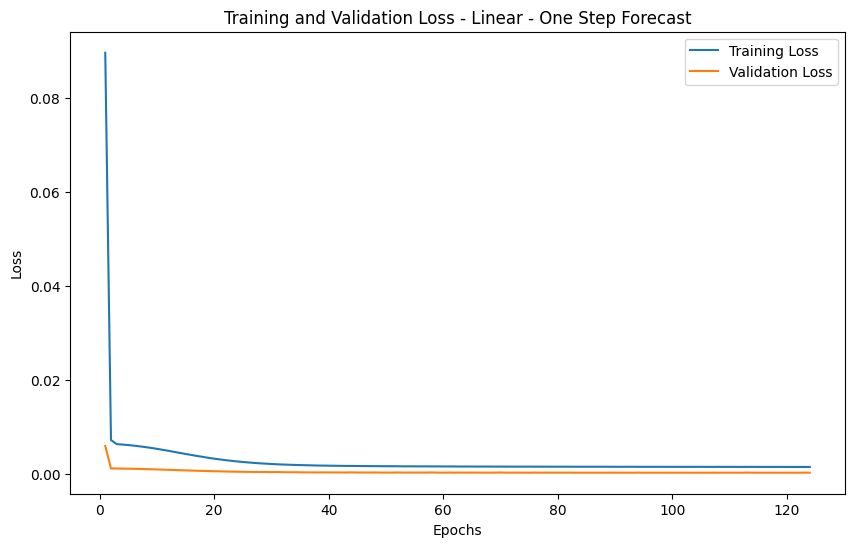

In [65]:
# linear model loss plot

linear_train_loss = linear_history.history['loss']
linear_val_loss = linear_history.history['val_loss']
epochs = range(1, len(linear_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, linear_train_loss, label='Training Loss')
plt.plot(epochs, linear_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Linear - One Step Forecast')
plt.legend()
# plt.show()
plt.savefig('linear.jpeg')

The loss plot for the linear model clearly shows that the validation loss (orange line) is consistently lower and parallel to the training loss (blue line). This is a great sign! It means our simple model is generalizing perfectly and has successfully captured the main, easy-to-find patterns in differenced and scaled temperature data without trying to memorize any specific noise from the training examples (which is called overfitting).

In [56]:
min(linear_history.history['val_mae'])
# this is in different scale than naive forecast and ARIMA AUTO ARIMA. Hence we need to inverse transform

0.016388535499572754

In [66]:
y_pred_scaled = linear_model.predict(valid_ds)

# extract the targets from valid_ds itself
y_val_scaled = np.concatenate([y for x, y in valid_ds], axis=0)

# inverse transform

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mae_linear = mean_absolute_error(y_val, y_pred)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [67]:
print("Best Validation MAE (linear model):", mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", (diff_year).abs().dropna().mean())

Best Validation MAE (linear model): 0.30858170220250186
MAE Manual ARIMA: 0.26469807440120835
MAE Auto ARIMA: 0.3135120769256071
Naive Forecast: 0.6570613867684478


The above sliding window (sequence to vector, one step forecast) model has no recurrent or convolution processing, the model just learns a linear (or non linear if we add activations) mapping from a fixed-length input sequence to one output.

Input: $[t-11, t-10, ..., t]$ -> 12 numbers

Dense layer does not know that $t-11$ comes before $t-10$ and so on.

It just applies a linear combination of all the 12 numbers (each multiplied by the weight) plus a bias, and outputs 1 number.

Mathematically,

$$
y_{pred} = w_1x_1 + w_2x_2+...+w_{12}x_{12} + b
$$

where

$x_1 = t-11, x_2=t-10, ..., x_{12} = t$

The dense layer treats all inputs equally, it does not know the order matters.

Dense layer treats input as a simple 12-element vector, no temporal dynamics.It takes the entire 12-step input vector and maps it to a single scalar output, the predicted value for the next month.

### Simple Recurrent Neural Network - Sequence to Vector - One Step Forecast

In [68]:
# creating RNN model - sequence to vector - one step forecast

tf.random.set_seed(42)

rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]), # variable sequence length, 1 feature (dimension 1 feature since we are predicting univariate time series)
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=False), # default activation
    tf.keras.layers.Dense(1, activation=None)
])

# Input: a sequence of shape [[t1], [t2], ..., [t12]] (one time series value per timestep from the sequence)
# RNN layer outputs only the **last hidden state** (h12), not all hidden states.
# Dense layer is applied to this last hidden state to produce a single output [o13].
# The model predicts **the next timestep** (e.g., next month) from the past sequence


In [69]:
print(rnn_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [70]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     min_delta=0.0001,
                                                     patience = 20,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

rnn_model.compile(loss = tf.keras.losses.Huber(),
                  optimizer=opt,
                  metrics=['mae']
                  )
rnn_history = rnn_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0074 - mae: 0.0792 - val_loss: 3.5559e-04 - val_mae: 0.0218
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - mae: 0.0394 - val_loss: 3.1212e-04 - val_mae: 0.0195
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0018 - mae: 0.0384 - val_loss: 6.4140e-04 - val_mae: 0.0308
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - mae: 0.0383 - val_loss: 2.1390e-04 - val_mae: 0.0161
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mae: 0.0376 - val_loss: 2.7440e-04 - val_mae: 0.0186
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0367 - val_loss: 2.6888e-04 - val_mae: 0.0179
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0368 - val_loss: 2.0246e-04 - val_mae: 0.0155
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mae: 0.0360 - val_loss: 3.0495e-04 - val_mae: 0.0198
Epoch 9/500
291/

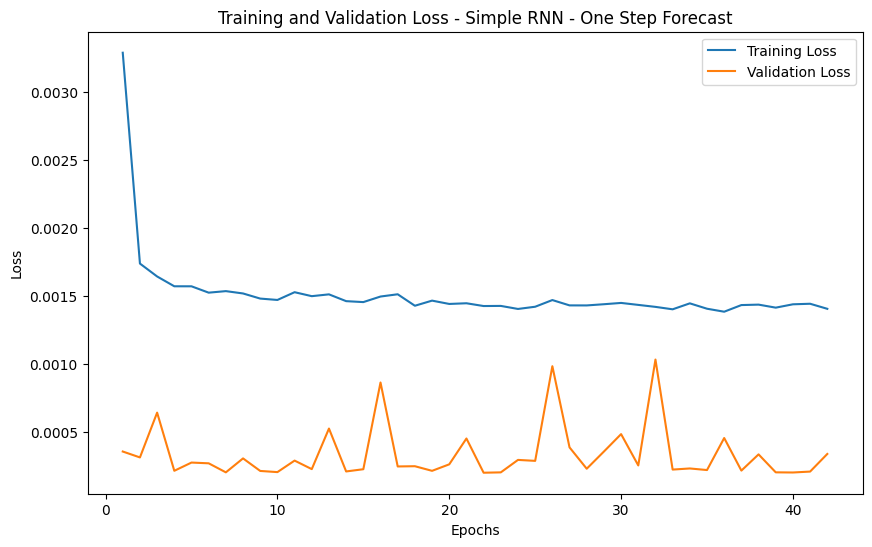

In [71]:
# RNN model loss plot

rnn_train_loss = rnn_history.history['loss']
rnn_val_loss = rnn_history.history['val_loss']
epochs = range(1, len(rnn_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, rnn_train_loss, label='Training Loss')
plt.plot(epochs, rnn_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Simple RNN - One Step Forecast')
plt.legend()
plt.show()
# plt.savefig("rnn_seq2vec_one_step.jpeg")


While the Validation Loss (orange line) remains low, two major issues are present:

Severe Underfitting: The Training Loss (blue line) drops quickly but then plateaus at a high value and fails to decrease further. This indicates the model has insufficient power to fully learn the patterns in the training data, suggesting a structural limitation.

Validation Instability: The Validation Loss (orange line) is highly spiky and volatile. Instead of a smooth curve, the fluctuations show that the model's generalization ability is changing dramatically with every batch of data it sees, indicating unstable learning.

Why the SimpleRNN is Not a Good Choice for Time Series?

The poor performance is a classic demonstration of the limitations of the SimpleRNN architecture:

Vanishing Gradients: SimpleRNNs struggle to pass information across long input sequences (in our case, 12 months). The gradient signal used for learning often becomes too small ("vanishes") by the time it reaches the first time steps, making it difficult for the model to use older data to make accurate predictions. This is the primary cause of the high, stuck Training Loss (underfitting).

Instability: The simple structure lacks the specialized "gates" found in modern RNNs (like GRUs and LSTMs) that regulate the flow of information. Without these gates, the network is highly sensitive to input noise and weight changes, leading to the chaotic, spiky behavior seen in the Validation Loss.

Conclusion: Due to its inability to maintain long-term dependencies and its high instability, the SimpleRNN is an inferior choice for this forecasting task compared to the more robust GRU or LSTM.

In [72]:
y_pred_scaled = rnn_model.predict(valid_ds)

# extract the targets from valid_ds itself
y_val_scaled = np.concatenate([y for x, y in valid_ds], axis=0)

# inverse transform
y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mae_rnn = mean_absolute_error(y_val, y_pred)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [73]:
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", mae_rnn)
print("Best Validation MAE (linear model):", mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", (diff_year).abs().dropna().mean())

Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.29142846401071804
Best Validation MAE (linear model): 0.30858170220250186
MAE Manual ARIMA: 0.26469807440120835
MAE Auto ARIMA: 0.3135120769256071
Naive Forecast: 0.6570613867684478


### GRU Model - Sequence to Vector - One Step Forecast

LSTM and GRU architectures have gating mechanisms designed to overcome the vanishing gradient probelm, allowing the model to effectively learn patterns that span many time steps.

Let's train the GRU models now

In [74]:
# gru model - sequence to vector, one step forecast

tf.random.set_seed(42)

gru_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.GRU(
        32,
        activation='tanh',
        return_sequences=False,
        # recurrent_dropout=0.05
    ),
    tf.keras.layers.Dense(1)
])

In [75]:
print(gru_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [76]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     min_delta=0.0001,
                                                     patience = 20,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

gru_model.compile(loss = tf.keras.losses.Huber(),
                  optimizer=opt,
                  metrics=['mae']
                  )

gru_history = gru_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0882 - mae: 0.3537 - val_loss: 3.5194e-04 - val_mae: 0.0202
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0022 - mae: 0.0410 - val_loss: 3.4826e-04 - val_mae: 0.0201
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0023 - mae: 0.0418 - val_loss: 3.5176e-04 - val_mae: 0.0204
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0022 - mae: 0.0413 - val_loss: 3.6382e-04 - val_mae: 0.0209
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0022 - mae: 0.0415 - val_loss: 3.3934e-04 - val_mae: 0.0199
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0022 - mae: 0.0408 - val_loss: 3.3461e-04 - val_mae: 0.0197
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0022 - mae: 0.0410 - val_loss: 3.9335e-04 - val_mae: 0.0221
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0022 - mae: 0.0406 - val_loss: 3.2811e-04 - val_mae: 0.0195
Epoch 9/500
291/

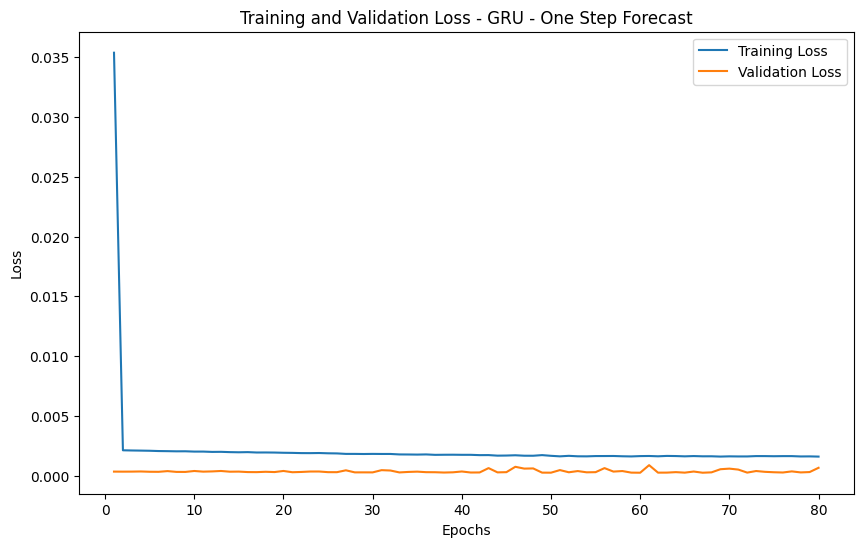

In [77]:
gru_train_loss = gru_history.history['loss']
gru_val_loss = gru_history.history['val_loss']
epochs = range(1, len(gru_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, gru_train_loss, label='Training Loss')
plt.plot(epochs, gru_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - One Step Forecast')
plt.legend()
plt.show()
# plt.savefig('gru_seq2vec_one_step.jpeg')

In [78]:
y_pred_scaled = gru_model.predict(valid_ds)

# extract the targets from valid_ds itself
y_val_scaled = np.concatenate([y for x, y in valid_ds], axis=0)

# inverse transform
y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mae_gru = mean_absolute_error(y_val, y_pred)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [79]:
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", mae_gru)
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", mae_rnn)
print("Best Validation MAE (linear model):", mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", (diff_year).abs().dropna().mean())

Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.3373791056650471
Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.29142846401071804
Best Validation MAE (linear model): 0.30858170220250186
MAE Manual ARIMA: 0.26469807440120835
MAE Auto ARIMA: 0.3135120769256071
Naive Forecast: 0.6570613867684478


The performance hierarchy for the 1-step forecast confirms the principle of Model Parsimony for highly pre-processed data:

Manual SARIMA: The overall winner, as it mathematically captures the linear/seasonal structure of the original data.

SimpleRNN: The best deep learning model for the transformed (differenced) series. Its simpler architecture is more efficient and less prone to optimization issues when modeling the residual, short-term correlations left after differencing.

GRU: Although structurally more advanced, its additional gates introduce complexity that is not needed for the short, stationary sequence, causing it to slightly underperform the simpler RNN.

In summary, we pushed the GRU as far as it could go, but for this specific problem (where the data has been transformed to remove the long-term dependencies the GRU is designed to handle), the SimpleRNN is the more effective and parsimonious choice among the deep learning models.

It demonstrates that advanced models are not always the best models.

The focus now shift entirely to the Multi-Step Forecasting task, as this is where the deep learning models (like the Seq2Seq architecture) usually regain their advantage over statistical models

### Linear Model - Sequence to Vector - Multi Step Forecast

In [80]:
# Creating the Direct Multi-Step Dataset (Predicts Y[t+1...t+12])

seq_length = 12 # input sequence
horizon = 12 # prediction horizoon

def create_multi_step_dataset(data_array, batch_size, shuffle=True):
  data_x = []
  data_y = []
  max_index = len(data_array) - seq_length - horizon
  for i in range(max_index+1):
    input_sequence = data_array[i:i+seq_length]
    target_sequence = data_array[i+seq_length:i+seq_length+horizon]
    data_x.append(input_sequence)
    data_y.append(target_sequence)

  X = np.array(data_x)
  Y = np.array(data_y)

  # convert to tensorflow dataset
  ds = tf.data.Dataset.from_tensor_slices((X,Y))
  ds = ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X), seed=42)
  ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

  return ds

In [81]:
train_ds_ms = create_multi_step_dataset(temp_train, batch_size=10, shuffle=True)
valid_ds_ms = create_multi_step_dataset(temp_valid, batch_size=5, shuffle=False)

In [82]:
# visualizing first two batches of data

for i, (x, y) in enumerate(train_ds_ms):
    print(f"Batch {i}")
    print("X (inputs):\n", x.numpy())
    print("Y (targets):\n", y.numpy())
    print("-"*30)
    if i == 0:  # stop after 2 batches
        break

Batch 0
X (inputs):
 [[[[0.53978967]]

  [[0.51389107]]

  [[0.51326322]]

  [[0.47637733]]

  [[0.47616805]]

  [[0.38868833]]

  [[0.57458274]]

  [[0.54387066]]

  [[0.46941872]]

  [[0.50054936]]

  [[0.50614765]]

  [[0.43698007]]]


 [[[0.45299011]]

  [[0.53199393]]

  [[0.51776278]]

  [[0.49877047]]

  [[0.46470988]]

  [[0.46015801]]

  [[0.51336786]]

  [[0.5124261 ]]

  [[0.46779679]]

  [[0.51828598]]

  [[0.49761942]]

  [[0.47109297]]]


 [[[0.52848846]]

  [[0.48412076]]

  [[0.50238058]]

  [[0.51478052]]

  [[0.44467117]]

  [[0.53534244]]

  [[0.58284937]]

  [[0.41218019]]

  [[0.39711191]]

  [[0.54256265]]

  [[0.45571077]]

  [[0.50897295]]]


 [[[0.50149113]]

  [[0.47799927]]

  [[0.52336106]]

  [[0.43535813]]

  [[0.53853398]]

  [[0.49144561]]

  [[0.49102705]]

  [[0.49311987]]

  [[0.47360435]]

  [[0.50635693]]

  [[0.50483964]]

  [[0.49202114]]]


 [[[0.48720766]]

  [[0.48971904]]

  [[0.36781248]]

  [[0.52765134]]

  [[0.5514048 ]]

  [[0.52644797]]


In [83]:
# Sequence to Vector, Direct Multi-Step Forecast (Predicts 12 values at once)

tf.random.set_seed(42)

linear_model_ms = tf.keras.Sequential([
    tf.keras.Input(shape=[12,1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation=None)
])

In [84]:
print(linear_model_ms.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156 (624.00 B)

 Trainable params: 156 (624.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [85]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

linear_model_ms.compile(loss = tf.keras.losses.Huber(),
                        optimizer=opt,
                        metrics=['mae']
                        )

linear_model_ms_history = linear_model_ms.fit(train_ds_ms,
                                              validation_data=valid_ds_ms,
                                              epochs=500,
                                              callbacks=[early_stopping_cb]
                                              )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1111 - mae: 0.3444 - val_loss: 0.0108 - val_mae: 0.0924
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097 - mae: 0.0938 - val_loss: 0.0010 - val_mae: 0.0356
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0045 - mae: 0.0624 - val_loss: 8.0252e-04 - val_mae: 0.0314
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043 - mae: 0.0603 - val_loss: 7.7850e-04 - val_mae: 0.0310
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041 - mae: 0.0594 - val_loss: 7.5468e-04 - val_mae: 0.0305
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040 - mae: 0.0584 - val_loss: 7.3026e-04 - val_mae: 0.0300
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - mae: 0.0574 - val_loss: 7.0556e-04 - val_mae: 0.0295
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - mae: 0.0564 - val_loss: 6.8089e-04 - val_mae: 0.0289
Epoch 9/500
291/291 ━━━━

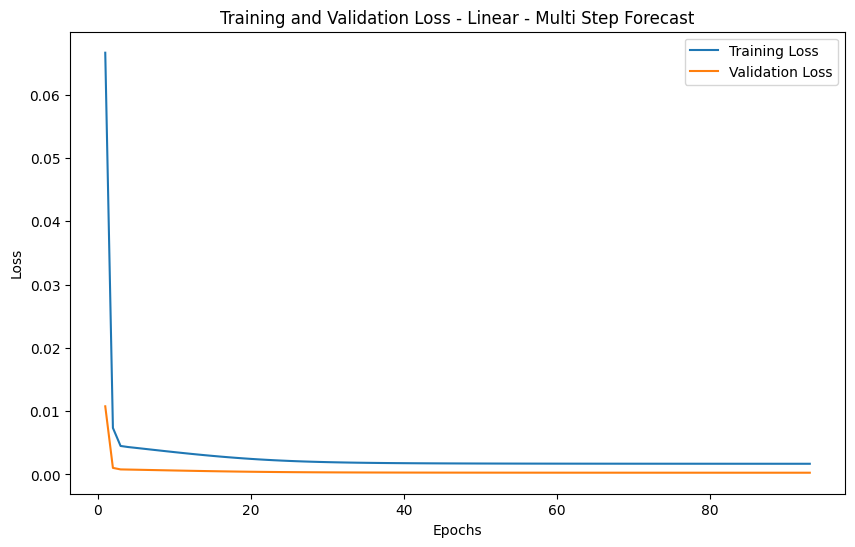

In [87]:
# linear model multistep plot

linear_ms_train_loss = linear_model_ms_history.history['loss']
linear_ms_val_loss = linear_model_ms_history.history['val_loss']
epochs = range(1, len(linear_ms_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, linear_ms_train_loss, label='Training Loss')
plt.plot(epochs, linear_ms_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Linear - Multi Step Forecast')
plt.legend()
plt.show()
# plt.savefig('linear_ms.jpeg')

The training and validation loss plot for the Linear Multi-Step Model (predicting 12 values at once) demonstrates extreme stability and serves as an ideal baseline for the task.

Immediate Convergence: The model converges almost instantly, with both training and validation loss reaching their floor within the first few epochs. This indicates that the optimal linear solution for predicting the next 12 steps is found very quickly.

High Stability: The loss curves are flat and parallel throughout the epochs, showing no signs of oscillation, overfitting, or underfitting. This confirms the model is highly robust.

Validation Loss Baseline: The stable validation loss value establishes the irreducible error for any linear model on this multi-step forecasting task.

In [88]:

# The valid_ds_ms dataset yields (X, Y) tuples.
# For model.predict(), we need a dataset that only yields X.
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

# This runs the model only on the X (features) tensors
y_pred_scaled = linear_model_ms.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

# Extract True Values
# This correctly extracts the Y (targets) tensors from the original dataset
y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

# Remove the redundant last dimension of size 1 using squeeze()
y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

# Inverse Transform

# Ensure both true values and predictions are back in the original temperature scale
y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

# The MAE is calculated across all 12 forecast steps for all samples
mae_linear_multistep = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions generated with shape: (181, 12)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [89]:
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", mae_gru)
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", mae_rnn)
print("Best Validation MAE (linear model):", mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", (diff_year).abs().dropna().mean())

Best Validation MAE (Linear Model with 12 step forecast): 0.35387220469123276
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.3373791056650471
Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.29142846401071804
Best Validation MAE (linear model): 0.30858170220250186
MAE Manual ARIMA: 0.26469807440120835
MAE Auto ARIMA: 0.3135120769256071
Naive Forecast: 0.6570613867684478


The comparison between Linear One-Step Forecast and the Linear Multi-Step Forecast demonstrates a fundamental principle of time series modeling: Forecasting complexity increases the mean error.

The significantly higher MAE in the multi-step model is expected and does not represent a modeling error. It is due to the difference in the calculated error:

Increased Error Propagation: In any multi-step forecast, the model is forced to predict points further out in time ($Y_{t+12}$ is harder to predict than $Y_{t+1}$). The error compounds across the horizon.

Average Error Metric: The MAE is the average error across all 12 predicted steps for every sample in the validation set.  It averages the small error of the near-term predictions ($Y_{t+1}$) with the much larger error of the far-term predictions ($Y_{t+12}$).

### Simple Recurrent Neural Network - Sequence to Vector - Multi Step Forecast

In [90]:
tf.random.set_seed(42)

rnn_model_multistep = tf.keras.Sequential([
    tf.keras.Input(shape=[12, 1]),
    tf.keras.layers.SimpleRNN(units=32),
    tf.keras.layers.Dense(12, activation=None)     # Output layer: Predicts all 12 future steps simultaneously (the target vector).
])

# Summary shows the much higher complexity compared to the Linear Model
rnn_model_multistep.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,484 (5.80 KB)

 Trainable params: 1,484 (5.80 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

rnn_model_multistep.compile(loss = tf.keras.losses.Huber(),
                            optimizer=opt,
                            metrics=['mae']
                            )

rnn_history_ms = rnn_model_multistep.fit(train_ds_ms,
                                         validation_data=valid_ds_ms,
                                         epochs=500,
                                         callbacks=[early_stopping_cb]
                                         )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0189 - mae: 0.1222 - val_loss: 4.5056e-04 - val_mae: 0.0235
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - mae: 0.0456 - val_loss: 4.3191e-04 - val_mae: 0.0230
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - mae: 0.0438 - val_loss: 4.1169e-04 - val_mae: 0.0225
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - mae: 0.0427 - val_loss: 3.9860e-04 - val_mae: 0.0221
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - mae: 0.0420 - val_loss: 3.8855e-04 - val_mae: 0.0218
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0020 - mae: 0.0414 - val_loss: 3.7984e-04 - val_mae: 0.0215
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mae: 0.0409 - val_loss: 3.7217e-04 - val_mae: 0.0213
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - mae: 0.0405 - val_loss: 3.6520e-04 - val_mae: 0.0211
Epoch 9/500
291/

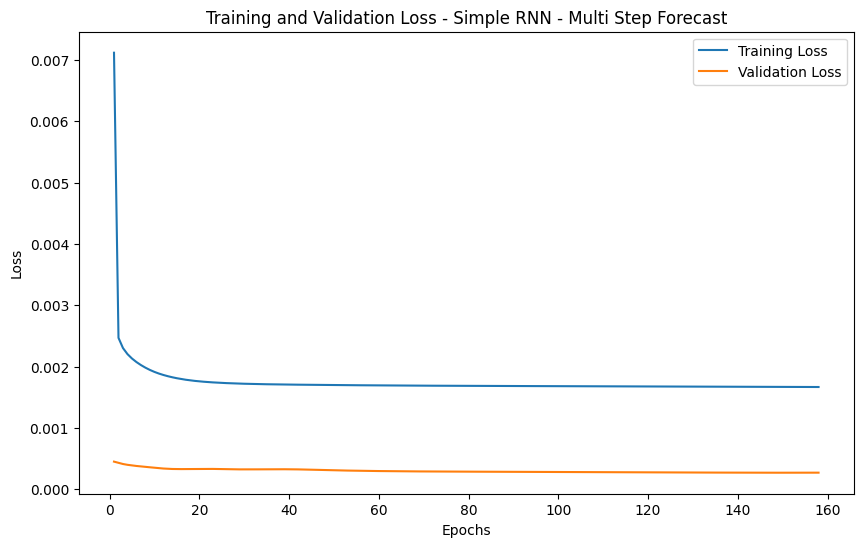

In [92]:
rnn_ms_train_loss = rnn_history_ms.history['loss']
rnn_ms_val_loss = rnn_history_ms.history['val_loss']
epochs = range(1, len(rnn_ms_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, rnn_ms_train_loss, label='Training Loss')
plt.plot(epochs, rnn_ms_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Simple RNN - Multi Step Forecast')
plt.legend()
plt.show()
# plt.savefig('rnn_ms.jpeg')

The loss plot shows the model converges quickly (around Epoch 20) and is highly stable, which is positive. The tuned EarlyStopping successfully triggered an early stop, demonstrating effective optimization control. However, the stabilized Validation Loss is slightly higher than the Linear Model's constant loss

In [93]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

y_pred_scaled = rnn_model_multistep.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

rnn_ms_mae = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predictions generated with shape: (181, 12)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [94]:
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Best Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", mae_gru)
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", mae_rnn)
print("Best Validation MAE (linear model):", mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", (diff_year).abs().dropna().mean())

Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3471563043374868
Best Validation MAE (Linear Model with 12 step forecast): 0.35387220469123276
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.3373791056650471
Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.29142846401071804
Best Validation MAE (linear model): 0.30858170220250186
MAE Manual ARIMA: 0.26469807440120835
MAE Auto ARIMA: 0.3135120769256071
Naive Forecast: 0.6570613867684478


### GRU Model - Sequence to Vector - Multi Step Forecasting


In [101]:
# gru model - sequence to vector, multi step forecast

tf.random.set_seed(42)

gru_model_ms = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.GRU(
        32,
        activation='tanh',
        return_sequences=False,
        # recurrent_dropout=0.05
    ),
    tf.keras.layers.Dense(12)
])

In [102]:
print(gru_model_ms.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,756 (14.67 KB)

 Trainable params: 3,756 (14.67 KB)

 Non-trainable params: 0 (0.00 B)

None


In [103]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

gru_model_ms.compile(loss = tf.keras.losses.Huber(),
                     optimizer=opt,
                     metrics=['mae']
                     )
gru_history__ms = gru_model_ms.fit(train_ds_ms,
                                   validation_data=valid_ds_ms,
                                   epochs=500,
                                   callbacks=[early_stopping_cb]
                                   )


Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0406 - mae: 0.2132 - val_loss: 4.0969e-04 - val_mae: 0.0218
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0428 - val_loss: 4.2024e-04 - val_mae: 0.0223
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mae: 0.0428 - val_loss: 4.2728e-04 - val_mae: 0.0225
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0022 - mae: 0.0428 - val_loss: 4.3082e-04 - val_mae: 0.0226
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0022 - mae: 0.0427 - val_loss: 4.3221e-04 - val_mae: 0.0227
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0022 - mae: 0.0427 - val_loss: 4.3256e-04 - val_mae: 0.0227
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0427 - val_loss: 4.3240e-04 - val_mae: 0.0227
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - mae: 0.0426 - val_loss: 4.3196e-04 - val_mae: 0.0227
Epoch 9/500
291/

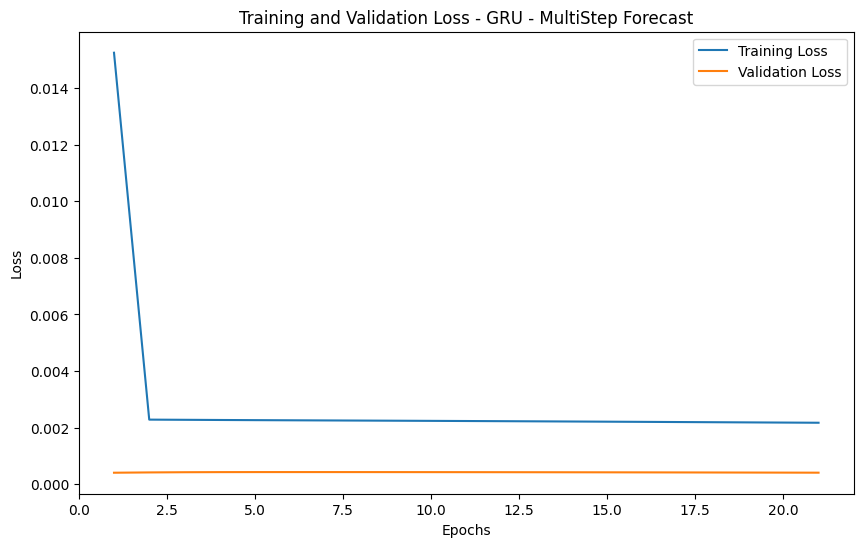

In [104]:
gru_ms_train_loss = gru_history__ms.history['loss']
gru_ms_val_loss = gru_history__ms.history['val_loss']
epochs = range(1, len(gru_ms_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, gru_ms_train_loss, label='Training Loss')
plt.plot(epochs, gru_ms_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - MultiStep Forecast')
plt.legend()
plt.show()
# plt.savefig('gru_ms.jpeg')

In [105]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

y_pred_scaled = gru_model_ms.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

gru_ms_mae = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predictions generated with shape: (181, 12)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [106]:
print("Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast):", gru_ms_mae)
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Validation MAE (Linear Model with 12 step forecast):", mae_linear_multistep)
print("Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", mae_gru)
print("Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", mae_rnn)
print("Validation MAE (linear model):", mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", (diff_year).abs().dropna().mean())

Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast): 0.41728595916927663
Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3471563043374868
Best Validation MAE (Linear Model with 12 step forecast): 0.35387220469123276
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.3373791056650471
Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.29142846401071804
Best Validation MAE (linear model): 0.30858170220250186
MAE Manual ARIMA: 0.26469807440120835
MAE Auto ARIMA: 0.3135120769256071
Naive Forecast: 0.6570613867684478


We have now completed the entire sequence to vector portion on the analysis for single step and multi step forecasting.

The analysis of the 12-step forecast confirmed that the Manual ARIMA model remains the overall benchmark for accuracy in this project. In the direct multi-step, Sequence-to-Vector (Seq2Vec) comparison, the SimpleRNN surprisingly outperformed both the Linear Model baseline and the GRU, proving more efficient at encoding the stationary sequence into a single context vector. The high failure rate of the GRU is attributed to its complex gates struggling with the information bottleneck created by forcing a single hidden state to predict all 12 future time steps. Despite the SimpleRNN's minor victory, the overall multi-step error is high, necessitating the architectural shift to the Sequence-to-Sequence (Seq2Seq) model to overcome the bottleneck and fully leverage the GRU's potential.

For many simple time series, a well-tuned ARIMA is impossible to beat.

Despite the dominance of ARIMA, the final step in a comprehensive deep learning time series analysis is to test the **Sequence-to-Sequence** architecture.

Sequence to Sequence models are different because they use **Encoder** (to read input sequences) and a **Decoder** (to generate the output sequence one step at a time, using the previous predicted step a input). These models are often the most effective for multi-step forecasting because they leverage the output sequence structure.


Now we will train sequence to sequence model. For sequence to sequence models: each input sequence should predict a full sequence. Model expects one output per input time step that is for 12 step input sequence, it expects 12 step target sequence. If we provide 1 step target, Keras cannot properly align inputs and outputs. It may pad zeros, or throw a shape mismatch warning or just learn incorrectly.

Since the GRU was the best Seq2Vec model, the next step is to build the GRU Seq2Seq model.

The Seq2Seq model structure requires two GRU layers:

Encoder GRU: Reads the 12 input steps.

Decoder GRU: Produces the 12 output steps. We will use a **TimeDistributed(Dense(1))** layer over the decoder output to generate the 12 forecast points.

In [107]:
tf.random.set_seed(42)

gru_model_seq2seq = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None,1]),
    tf.keras.layers.GRU( # Encoder GRU: Processes the input sequence
        units=32,
        activation='tanh',
        return_sequences=True, # must use True to output a sequence for the next layer
        recurrent_dropout=0.05
    ),
    tf.keras.layers.GRU( # Decoder GRU: Takes the Encoder's output sequence and transforms it
        units=32,
        activation='tanh',
        return_sequences=True, # Must be true to output a sequence of 12 steps
        recurrent_dropout=0.05
    ),
    # output layer, applies a single Dense(1) layer independently to each of the 12 time steps outputted by Decorder GRU.
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])


In [108]:
print(gru_model_seq2seq.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, None, 32)       │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, None, 32)       │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Note: The target shape for Seq2Seq is (batch_size, 12, 1),
# which is slightly different from the Seq2Vec target shape (batch_size, 12).

In [109]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_mae",
                                                     patience = 20,
                                                     min_delta = 0.0001,
                                                     restore_best_weights = True
                                                     )

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

gru_model_seq2seq.compile(loss = tf.keras.losses.Huber(),
                          optimizer=opt,
                          metrics=['mae']
                          )

gru_history_seq2seq = gru_model_seq2seq.fit(train_ds_ms,
                                            validation_data=valid_ds_ms,
                                            epochs=500,
                                            callbacks=[early_stopping_cb]
                                            )

Epoch 1/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0185 - mae: 0.1365 - val_loss: 0.0013 - val_mae: 0.0342
Epoch 2/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0032 - mae: 0.0537 - val_loss: 5.1818e-04 - val_mae: 0.0243
Epoch 3/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0025 - mae: 0.0467 - val_loss: 3.9990e-04 - val_mae: 0.0215
Epoch 4/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0022 - mae: 0.0427 - val_loss: 3.2112e-04 - val_mae: 0.0195
Epoch 5/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0018 - mae: 0.0390 - val_loss: 2.8523e-04 - val_mae: 0.0186
Epoch 6/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0017 - mae: 0.0379 - val_loss: 2.7402e-04 - val_mae: 0.0183
Epoch 7/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0017 - mae: 0.0374 - val_loss: 2.8496e-04 - val_mae: 0.0190
Epoch 8/500
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0017 - mae: 0.0371 - val_loss: 2.7334e-04 - val_mae: 0.0184
Epoch 9/500


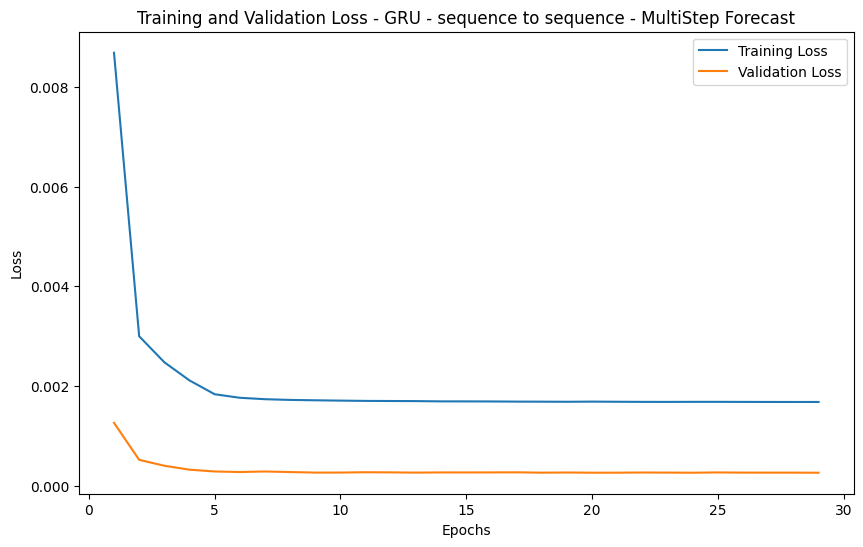

In [110]:
# GRU model seq2seq multistep plot

gru_seq2seq_train_loss = gru_history_seq2seq.history['loss']
gru_seq2seq_val_loss = gru_history_seq2seq.history['val_loss']
epochs = range(1, len(gru_seq2seq_train_loss)+1)

plt.figure(figsize=(10,6))

plt.plot(epochs, gru_seq2seq_train_loss, label='Training Loss')
plt.plot(epochs, gru_seq2seq_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - GRU - sequence to sequence - MultiStep Forecast')
plt.legend()
plt.show()
# plt.savefig('gru_ms_seq.jpeg')

The loss plot shows immediate, sharp convergence in the first few epochs, demonstrating that the model quickly found a highly optimal set of weights. The Validation Loss line (orange) is clean and stable, indicating great generalization, and the Early Stopping successfully halted training after minimal further improvement.

In [111]:
print("Preparing prediction dataset...")
valid_ds_predict = valid_ds_ms.map(lambda x, y: x)

y_pred_scaled = gru_model_seq2seq.predict(valid_ds_predict)
print(f"Predictions generated with shape: {y_pred_scaled.shape}")

y_val_scaled_3d = np.concatenate([y for x, y in valid_ds_ms], axis=0)
print(f"True values extracted with shape: {y_val_scaled_3d.shape}")

y_val_scaled = y_val_scaled_3d.squeeze()
print(f"True values squeezed to shape: {y_val_scaled.shape}")

y_val = scaler.inverse_transform(y_val_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.squeeze())

gru_seq2seq_mae = mean_absolute_error(y_val, y_pred)

Preparing prediction dataset...
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Predictions generated with shape: (181, 12, 1)
True values extracted with shape: (181, 12, 1)
True values squeezed to shape: (181, 12)


In [112]:
print("Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast:", gru_seq2seq_mae)
print("Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast):", gru_ms_mae)
print("Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast):", rnn_ms_mae)
print("Best Validation MAE (Linear Model, 12 step forecast):", mae_linear_multistep)
print("Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast):", mae_gru)
print("Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast):", mae_rnn)
print("Best Validation MAE (linear model, 1 step forecast):", mae_linear)
print("MAE Manual ARIMA:", mae_manual)
print("MAE Auto ARIMA:", mae_auto)
print("Naive Forecast:", (diff_year).abs().dropna().mean())

Validation MAE (GRU with Encoder and Decoder, 32 neurons, all hidden state, 12 step forecast: 0.34049656221636737
Validation MAE (GRU 32 neuron, last hidden state, 12 step forecast): 0.41728595916927663
Validation MAE (Simple RNN 32 neuron, last hidden state, 12 step forecast): 0.3471563043374868
Best Validation MAE (Linear Model, 12 step forecast): 0.35387220469123276
Best Validation MAE (GRU with 32 neuron and last hidden state, 1 step forecast): 0.3373791056650471
Best Validation MAE (RNN with 32 neuron and last hidden state, 1 step forecast): 0.29142846401071804
Best Validation MAE (linear model, 1 step forecast): 0.30858170220250186
MAE Manual ARIMA: 0.26469807440120835
MAE Auto ARIMA: 0.3135120769256071
Naive Forecast: 0.6570613867684478


The final evaluation of the multi-step models confirms the importance of architecture in solving the information bottleneck problem. The newly implemented GRU Encoder-Decoder (Seq2Seq) model achieved the best deep learning performance for the 12-step forecast. This model successfully surpassed the previous best recurrent model, the SimpleRNN, and the Linear Model baseline. The significant performance jump validates the architectural shift: the Seq2Seq structure, which allows the GRU to return predictions at every output time step, was necessary to utilize the model's capacity effectively. This also contrasts sharply with the disastrous performance of the original GRU Seq2Vec model, solidifying the conclusion that the complexity of the GRU's gates is only beneficial when paired with the flexible Seq2Seq decoding mechanism